In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti, step

import torch
from torch.utils.data import Dataset
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Functions

In [9]:
def gen_stable_poly(order):
    # Generate stable poles: random real parts < 0
    real_parts = -np.random.uniform(0.05, 5.0, size=order)  # random numbers in (-5, -0.5)
    imag_parts = np.random.uniform(-2, 2, size=order)      # imaginary parts

    # Combine real and imaginary parts to make complex conjugate poles
    poles = real_parts + 1j * imag_parts

    # Make sure to include the complex conjugates for a real-valued system
    poles = np.concatenate([poles, np.conj(poles)])
    poles = np.real_if_close(poles)  # Clean up near-zero imaginary parts

    den = np.poly(poles)
    return den

def gain_for_unit(num, den):
    b0 = np.polyval(num, 0)
    a0 = np.polyval(den, 0)
    gain = a0 / b0
    return gain

In [10]:
def gen_lti_simple(order_den, gain_mul=None):    
    num = np.array([1.])
    den = gen_stable_poly(order_den)
    num *= gain_for_unit(num, den)
    if gain_mul:
        num *= gain_mul
    #print(num, list(den))
    system = lti(num, den)
    return system

def gen_lti(order_num, order_den, gain_mul=None): 
    # choices = np.array([0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5])
    # choices = np.concatenate([choices,-choices])
    # num = choices[np.random.choice(len(choices), order_num)]
    num = np.random.uniform(-5., 5.0, size=order_num)
    den = gen_stable_poly(order_den)
    num *= gain_for_unit(num, den)
    if gain_mul:
        num *= gain_mul
    #print(num, list(den))
    system = lti(num, den)
    return system

In [11]:
def sim_response_step(system, max_t, num_t):
    t = np.linspace(0, max_t, num_t)
    t_out, y = step(system, T=t)
    return t_out, y

In [12]:
def gen_gamma_gains(count, a, b):
    if a is not None and b is not None:
        rng = np.random.default_rng()
        gains = rng.gamma(a, b, size=count)
        mode = a/b
        gains /= mode * 1.1
        gains += 0.1
    else:
        gains = None
    return gains

def gen_response_lti_simple(num_traces, order_den, max_t, num_t, neg_gain_p=None, a=None, b=None):
    out = []

    gains = gen_gamma_gains(num_traces, a, b)

    for i in range(num_traces):
        gain_mul = 1
        
        if neg_gain_p is not None:
            if np.random.rand() < neg_gain_p:
                gain_mul = -1

        if gains is not None:
            gain_mul *= gains[i]
            
        system = gen_lti_simple(order_den, gain_mul)
        t_out, y = sim_response_step(system, max_t, num_t)
        out.append(y)
    
    out = np.stack(out)
    return t_out, out


def gen_response_lti(num_traces, order_num, order_den, max_t, num_t, neg_gain_p=None, a=None, b=None):
    out = []

    gains = gen_gamma_gains(num_traces, a, b)

    for i in range(num_traces):
        gain_mul = 1
        
        if neg_gain_p is not None:
            if np.random.rand() < neg_gain_p:
                gain_mul = -1

        if gains is not None:
            gain_mul *= gains[i]

        system = gen_lti(order_num, order_den, gain_mul)
        t_out, y = sim_response_step(system, max_t, num_t)
        out.append(y)
    
    out = np.stack(out)
    return t_out, out

# Generate Data

In [6]:
num_points = 60 * 24 * 7

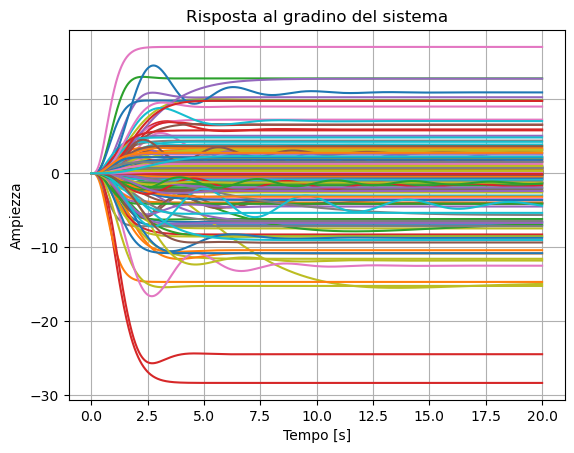

In [44]:
t, y0 = gen_response_lti_simple(180, 2, 20, 1000, neg_gain_p=0.5, a=1/2, b=2)
for line in y0:
    plt.plot(t, line)

plt.title('Risposta al gradino del sistema')
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza')
plt.grid(True)
plt.show()


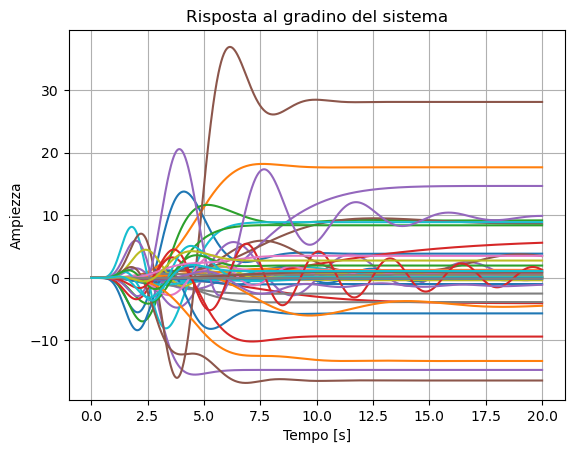

In [18]:
_, y1 = gen_response_lti(50, 4, 6, 20, 1000, neg_gain_p=0.5, a=1/2, b=2)
for line in y1:
    plt.plot(t, line)

plt.title('Risposta al gradino del sistema')
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza')
plt.grid(True)
plt.show()


<>:11: SyntaxWarning: "is not" with 'float' literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with 'float' literal. Did you mean "!="?
/tmp/ipykernel_20209/1852094506.py:11: SyntaxWarning: "is not" with 'float' literal. Did you mean "!="?
  if 0.5 is not None:


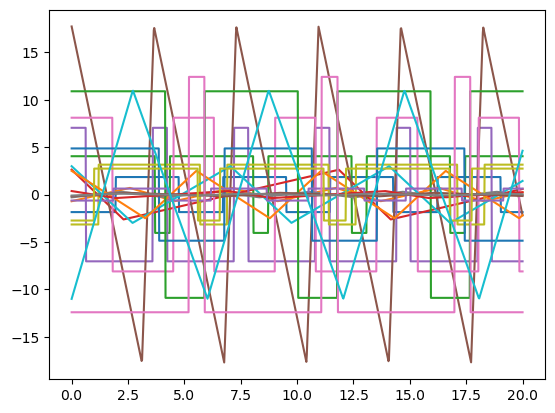

In [22]:
import scipy

y2 = []

gains = gen_gamma_gains(20, 1/2, 2)
f = gen_gamma_gains(20, 10, 1) * 0.2

for i in range(20):
    gain_mul = 1
    
    if 0.5 is not None:
        if np.random.rand() < 0.5:
            gain_mul = -1

    if gains is not None:
        gain_mul *= gains[i]

    duty = np.random.uniform(low=0.1, high=0.9)

    if i % 2 == 0:
        pwm = scipy.signal.square(2 * np.pi * f[i] * t, duty=duty) * gain_mul
    else:
        pwm = scipy.signal.sawtooth(2 * np.pi * f[i] * t, width=duty) * gain_mul
    y2.append(pwm)

y2 = np.array(y2)

plt.figure()
for line in y2:
    plt.plot(t, line)

plt.show()

In [23]:
y = np.concatenate([y0,y1,y2], axis=0)
#y = y0.copy()
y.shape

(250, 1000)

In [25]:
import pickle as pk
with open("y.pkl", "wb") as f:
    #pk.dump(y, f)
    pass

In [45]:
del y0
del y1

NameError: name 'y1' is not defined

# Train

In [13]:
import pickle as pk
with open("y.pkl", "rb") as f:
    #pk.dump(y, f)
    y = pk.load(f)
y.shape

(250, 1000)

In [14]:
class SlidingWindowDataset(Dataset):
    def __init__(self, data: np.ndarray, window_size: int, step_size: int = 1):
        """
        data: numpy array of shape (num_traces, trace_length)
        window_size: length of each sub-window
        step_size: stride between sub-windows
        """
        self.device = device
        self.data = torch.from_numpy(data).float().to(self.device)
        self.window_size = window_size
        self.step_size = step_size

        num_traces, trace_len = self.data.shape
        self.subwindows_per_trace = (trace_len - window_size) // step_size + 1

        self.total_windows = num_traces * self.subwindows_per_trace

    def __len__(self):
        return self.total_windows

    def __getitem__(self, idx):
        trace_idx = idx // self.subwindows_per_trace
        window_idx = idx % self.subwindows_per_trace

        start = window_idx * self.step_size
        end = start + self.window_size

        window = self.data[trace_idx, start:end]
        return window

window_size = 100
base_dataset = SlidingWindowDataset(y, window_size=window_size, step_size=5)

print("Dataset len: ", len(base_dataset))  # (1000 - 100) + 1 = 901 finestre per traccia × 800 = 720800
print("Dataset window shape: ", base_dataset[0].shape)  # torch.Size([100])
print("Dataset device: ", base_dataset.device)

Dataset len:  45250
Dataset window shape:  torch.Size([100])
Dataset device:  cuda


In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class SimCLRTimeSeriesDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x = self.base_dataset[idx]
        v1 = self.augment(x)
        v2 = self.augment(x)
        return v1, v2

    def masked_jitter(self, x, sigma=0.01, p=0.25):
        mask = np.random.rand(len(x))
        mask = mask < p
        noise = torch.randn_like(x)
        noise *= sigma * (torch.max(x)-torch.min(x))
        noise[~mask] = 0.
        return x + noise
    
    def augment(self, x):
        o = np.random.normal(0, 0.07) * x[-1]
        x = x * np.random.normal(1, 0.07)
        x = self.masked_jitter(x, 0.01, 0.4)
        return x + o

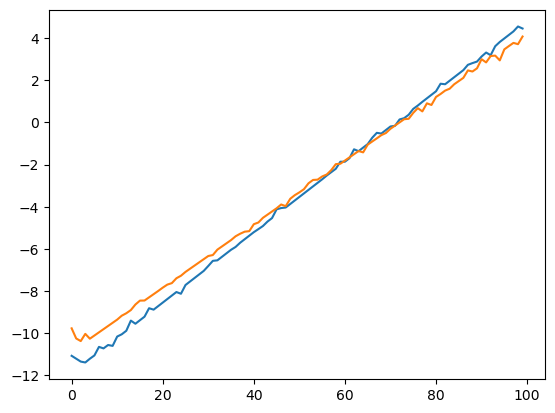

In [16]:
simclr_dataset = SimCLRTimeSeriesDataset(base_dataset)

plt.plot(simclr_dataset[-1][0].cpu())
plt.plot(simclr_dataset[-1][1].cpu())
plt.show()

In [17]:
def nt_xent_loss(z1, z2, temperature=0.5):
    """
    z1, z2: (B, D) normalized
    """
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # (2B, 2B)

    # Labels: positive pair for i is i + B (and vice versa)
    labels = torch.arange(batch_size, device=z.device)
    labels = torch.cat([labels + batch_size, labels])

    # Mask out self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim_matrix = sim_matrix[~mask].view(2 * batch_size, -1)

    positives = torch.cat([
        F.cosine_similarity(z1, z2),
        F.cosine_similarity(z2, z1)
    ], dim=0)

    logits = sim_matrix / temperature
    loss = -torch.log(torch.exp(positives / temperature) / torch.exp(logits).sum(dim=1))
    return loss.mean()


In [73]:
import torch.nn as nn
import torch.nn.functional as F

class ConvEncoder(nn.Module):
    def __init__(self, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding='valid'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 128, kernel_size=5, stride=1, padding='valid'),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.projection_head = nn.Sequential(
            #nn.Dropout(0.1),
            nn.Linear(128, 256),
            #nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # shape: (B, 1, N)
        features = self.encoder(x).squeeze(-1)  # shape: (B, 64)
        out = self.projection_head(features)  # shape: (B, projection_dim)
        return F.normalize(out, dim=1)


In [74]:
def train_simclr(model, dataloader, device, epochs=10):
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0.0
        for x1, x2 in dataloader:
            x1, x2 = x1.to(device), x2.to(device)
            z1 = model(x1)
            z2 = model(x2)
            loss = nt_xent_loss(z1, z2)
            #print(z1.device, loss.device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg:.4f}")


In [75]:
model = ConvEncoder(projection_dim=128)
sum(p.numel() for p in model.parameters())

86720

In [169]:
from torch.utils.data import DataLoader

torch.cuda.empty_cache()
loader = DataLoader(simclr_dataset, batch_size=800, shuffle=True)

try:
    train_simclr(model, loader, device='cuda', epochs=200)
except:
    torch.cuda.empty_cache()

Epoch 1/200 - Loss: 5.7172
Epoch 2/200 - Loss: 5.6546
Epoch 3/200 - Loss: 5.6513
Epoch 4/200 - Loss: 5.6462
Epoch 5/200 - Loss: 5.6480
Epoch 6/200 - Loss: 5.6466
Epoch 7/200 - Loss: 5.6462
Epoch 8/200 - Loss: 5.6452
Epoch 9/200 - Loss: 5.6482
Epoch 10/200 - Loss: 5.6430
Epoch 11/200 - Loss: 5.6459
Epoch 12/200 - Loss: 5.6402
Epoch 13/200 - Loss: 5.6403
Epoch 14/200 - Loss: 5.6412
Epoch 15/200 - Loss: 5.6412


In [170]:
#del model
torch.cuda.empty_cache()

# Test0

In [171]:
y.shape

(250, 1000)

In [172]:
model.eval()

ConvEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=valid)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 128, kernel_size=(5,), stride=(1,), padding=valid)
    (4): ReLU()
    (5): AdaptiveAvgPool1d(output_size=1)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [173]:
def embed_rolling(x, w):
    print(x.shape, w)
    x = [
        x[i:i+w] for i in range(len(x)-w)
    ]
    x = np.array(x)
    return model(torch.from_numpy(x).to(device).float()).cpu().detach().numpy().T

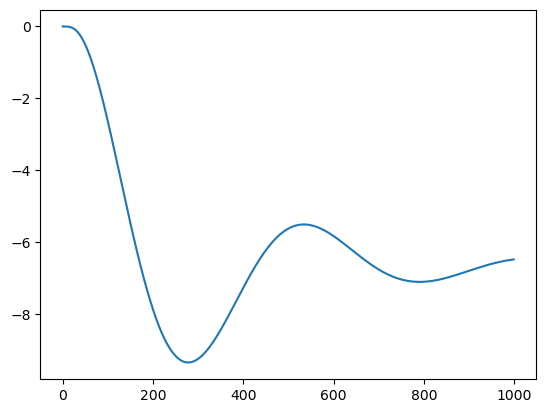

In [174]:
x_rnd = y[0]
plt.plot(x_rnd)
plt.show()

(1000,) 100
(128, 900)


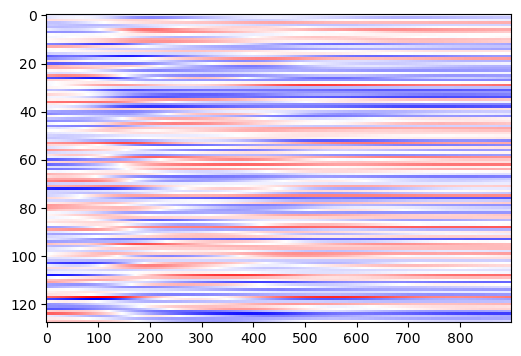

In [175]:
pred = embed_rolling(x_rnd, window_size)
print(pred.shape)

plt.figure(figsize=(6, 4))
plt.imshow(pred, cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

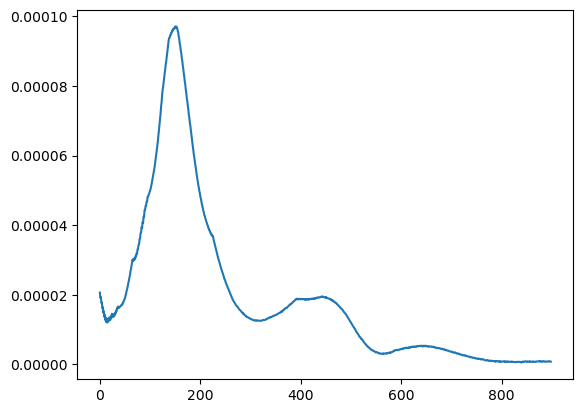

In [176]:
from scipy.spatial import distance
lag = 1
cum_dist = -F.cosine_similarity(
    torch.tensor(pred[:,:-lag]), torch.tensor(pred[:,lag:]), dim=0
).numpy()
#cum_dist -= np.min(cum_dist)
#cum_dist /= np.max(cum_dist)
#cum_dist = equalize_hist(cum_dist)
cum_dist = -np.log(-cum_dist)
plt.plot(cum_dist)
plt.show()

In [177]:
len(t)

1000

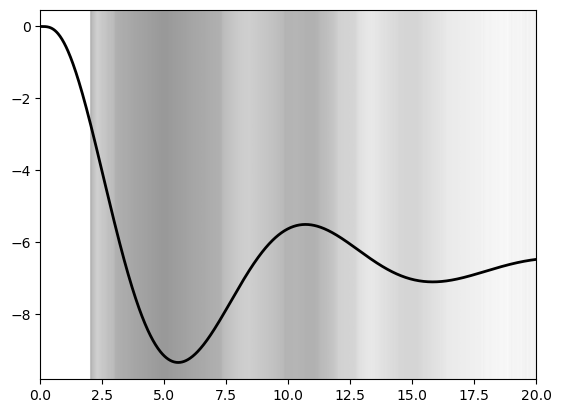

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Create figure and axis
fig, ax = plt.subplots()

# Plot your line
ax.plot(t, x_rnd, color='black', linewidth=2)

# Add a colormap background using imshow
# Reshape values to (1, len(x)) so it's a 1-row image
cmap = plt.get_cmap('binary')
extent = [t.min(), t.max(), ax.get_ylim()[0], ax.get_ylim()[1]]

col_values = np.concatenate([
    np.zeros(len(x_rnd)-len(cum_dist)), cum_dist
])
col_values = equalize_hist(col_values)
ax.imshow(col_values.reshape(1, -1), aspect='auto', cmap=cmap,
          extent=extent, alpha=0.4)

plt.show()

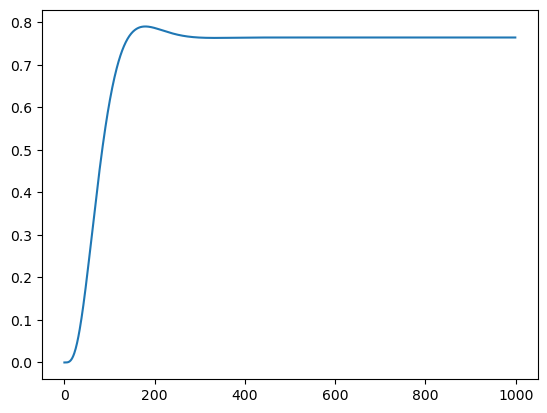

In [179]:
x_rnd = y[30]
plt.plot(x_rnd)
plt.show()

(1000,) 100


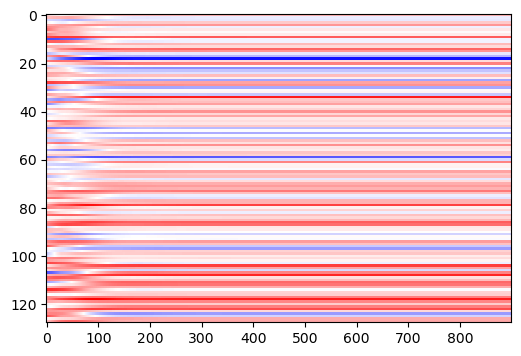

In [180]:
torch.from_numpy(x_rnd)
pred = embed_rolling(x_rnd, window_size)

plt.figure(figsize=(6, 4))
plt.imshow(pred[:,:], cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

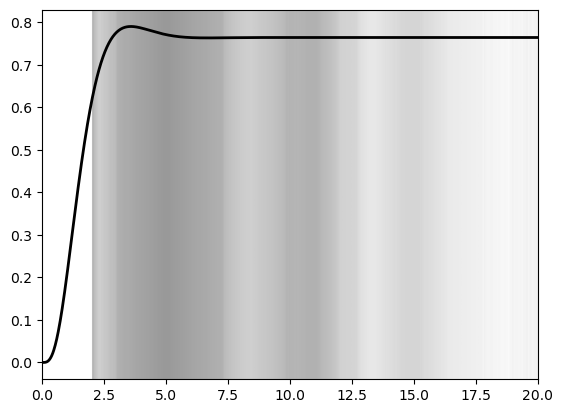

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Create figure and axis
fig, ax = plt.subplots()

# Plot your line
ax.plot(t, x_rnd, color='black', linewidth=2)

# Add a colormap background using imshow
# Reshape values to (1, len(x)) so it's a 1-row image
cmap = plt.get_cmap('binary')
extent = [t.min(), t.max(), ax.get_ylim()[0], ax.get_ylim()[1]]

col_values = np.concatenate([
    np.zeros(len(x_rnd)-len(cum_dist)), cum_dist
])
col_values = equalize_hist(col_values)
ax.imshow(col_values.reshape(1, -1), aspect='auto', cmap=cmap,
          extent=extent, alpha=0.4)

plt.show()

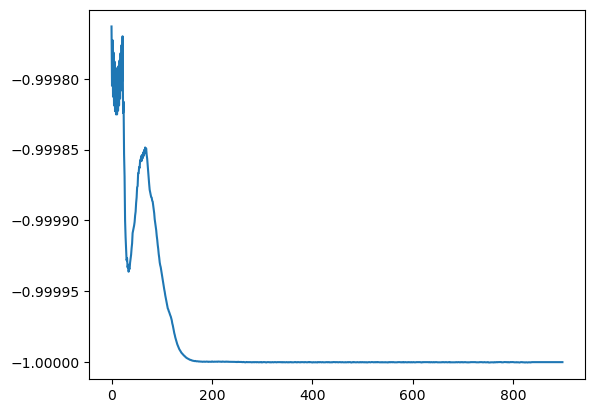

In [182]:
from scipy.spatial import distance
lag = 1
cum_dist = -F.cosine_similarity(
    torch.tensor(pred[:,:-lag]), torch.tensor(pred[:,lag:]), dim=0
).numpy()
plt.plot(cum_dist)
plt.show()

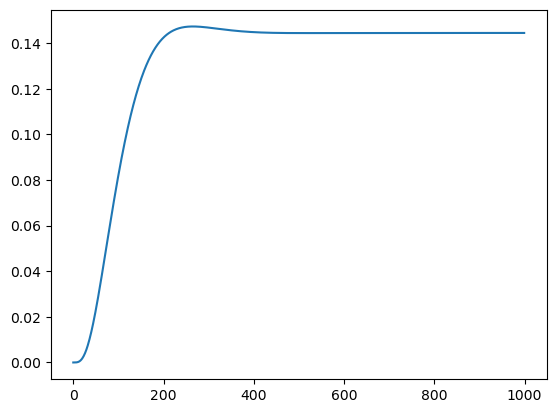

In [183]:
x_rnd = y[5]
plt.plot(x_rnd)
plt.show()

# Test1

In [202]:
def embed(x):
    return model(torch.from_numpy(np.array([x])).to(device).float()).cpu().detach().numpy().T

def embed_many(x):
    return model(torch.from_numpy(x).to(device).float()).cpu().detach().numpy().T

In [203]:
y_embed = embed_many(np.array([xx.cpu() for xx in base_dataset]))
y_embed.shape

(128, 45250)

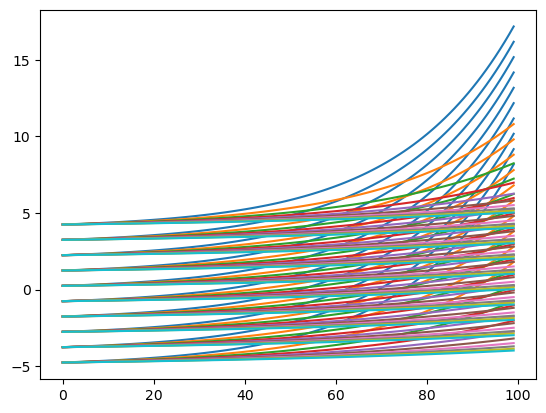

In [204]:
c0_ex0 = []
for o in range(10):
    offset = o - 5
    for i in range(10):
        t_curr = t[:window_size] / (i/10+0.5)
        c0_ex0.append(np.exp(t_curr) / 4 + offset)
c0_ex0 = np.array(c0_ex0).T
plt.plot(c0_ex0)
plt.show()

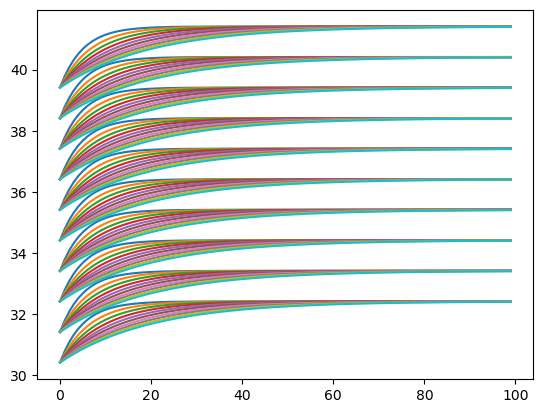

In [205]:
c0_ex1 = []
for o in range(10):
    offset = o - 4.5
    for i in range(10):
        t_curr = t[:window_size]
        y_curr = np.exp(-t_curr  / (i/30+0.1)) * 2
        y_curr = np.max(y) - y_curr
        c0_ex1.append(y_curr  + offset)
c0_ex1 = np.array(c0_ex1).T
plt.plot(c0_ex1)
plt.show()

(100, 100) (100, 100)


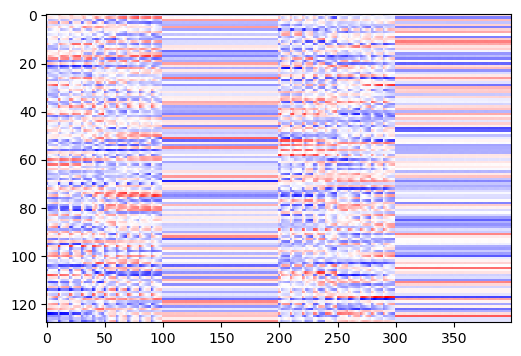

In [216]:
print(c0_ex0.shape, c0_ex1.shape)
pred1 = embed_many(c0_ex0.T)
pred2 = embed_many(c0_ex1.T)
pred_neg1 = embed_many(-c0_ex0.T)
pred_neg2 = embed_many(-c0_ex1.T)

plt.figure(figsize=(6, 4))
plt.imshow(np.concatenate([
    pred1, pred2, pred_neg1, pred_neg2
], axis=1), cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

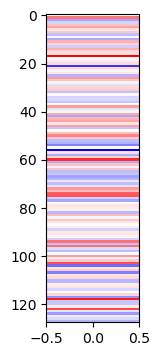

In [275]:
c0_ex0_emb = 10*np.sum(pred1, axis=1) - 5*np.sum(pred_neg1, axis=1) - 1*np.sum(pred2, axis=1)
norm = np.linalg.norm(c0_ex0_emb)
if norm != 0.:
    c0_ex0_emb = c0_ex0_emb / norm

plt.figure(figsize=(1.2, 4))
plt.imshow(np.array([c0_ex0_emb]).T, cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

In [276]:
import numpy as np
from sklearn.preprocessing import normalize

def top_k_cosine(query, database, k=5, normalized=False):
    """
    Find top-k most similar embeddings in `database` to `query` using cosine similarity.
    
    Parameters:
        query: np.ndarray of shape (D,) or (B, D)
        database: np.ndarray of shape (N, D)
        k: top-k elements to return
        normalized: whether inputs are already L2-normalized
        
    Returns:
        top_k_indices: np.ndarray of shape (k,) or (B, k)
        top_k_scores: np.ndarray of shape (k,) or (B, k)
    """
    query = np.atleast_2d(query)  # (1, D) if single
    if not normalized:
        query = normalize(query, axis=1)
        database = normalize(database, axis=1)

    scores = np.dot(query, database.T)  # shape (B, N)
    
    if scores.shape[0] == 1:
        top_k_idx = np.argpartition(scores[0], -k)[-k:]
        sorted_idx = top_k_idx[np.argsort(scores[0][top_k_idx])[::-1]]
        return sorted_idx, scores[0][sorted_idx]
    else:
        top_k_idx = np.argpartition(scores, -k, axis=1)[:, -k:]
        sorted_idx = np.argsort(np.take_along_axis(scores, top_k_idx, axis=1), axis=1)[:, ::-1]
        top_k_indices = np.take_along_axis(top_k_idx, sorted_idx, axis=1)
        top_k_scores = np.take_along_axis(scores, top_k_indices, axis=1)
        return top_k_indices, top_k_scores


In [277]:
top_k_search = top_k_cosine(c0_ex0_emb, y_embed.T, k=30)

In [278]:
top_k_search

(array([35160, 35161, 35162, 35159, 43655, 43766, 43710, 43765, 35163,
        43711, 43656, 43654, 43709, 43767, 43764, 43712, 43657, 43653,
        43708, 35164, 43768, 43763, 43713, 35158, 33444, 43658, 33445,
        35165, 43652, 33443]),
 array([0.8319954 , 0.8314078 , 0.82425416, 0.82159746, 0.81453943,
        0.8142566 , 0.814237  , 0.8134854 , 0.81344986, 0.81324124,
        0.81254137, 0.8117535 , 0.8100054 , 0.8096937 , 0.8085512 ,
        0.80811995, 0.8056841 , 0.803921  , 0.80107385, 0.8010175 ,
        0.7992507 , 0.7982156 , 0.7952306 , 0.7947519 , 0.7937486 ,
        0.7916735 , 0.7912189 , 0.78870285, 0.7870369 , 0.78682834],
       dtype=float32))

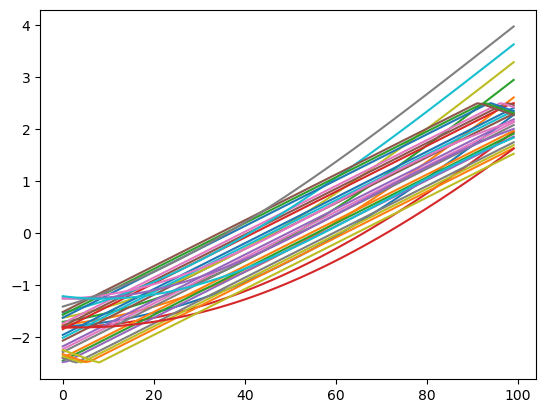

In [279]:
for i in top_k_search[0]:
    line = base_dataset[i].cpu()
    plt.plot(line)
plt.show()

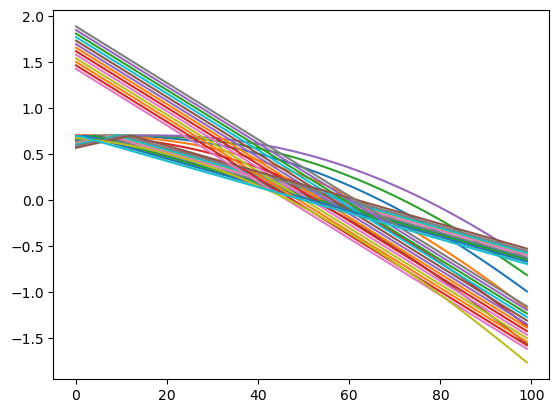

In [280]:
top_k_search = top_k_cosine(-c0_ex0_emb, y_embed.T, k=30)
for i in top_k_search[0]:
    line = base_dataset[i].cpu()
    plt.plot(line)
plt.show()

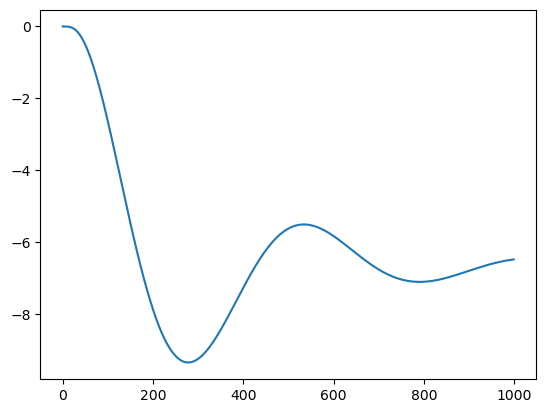

In [281]:
x_rnd = y[0]
plt.plot(x_rnd)
plt.show()

In [296]:
embed_rnd = embed_rolling(x_rnd, window_size)
embed_rnd.shape

(1000,) 100


(128, 900)

(128, 899)


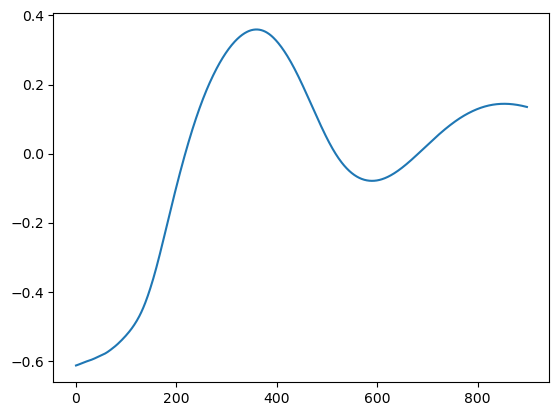

In [303]:
lag=1
c0_ex0_emb_rpt = np.array([c0_ex0_emb for i in range(len(x_rnd)-window_size-1)]).T
print(c0_ex0_emb_rpt.shape)
cum_dist = -F.cosine_similarity(
    torch.tensor(embed_rnd[:,:-lag]), torch.from_numpy(c0_ex0_emb_rpt), dim=0
).numpy()
#cum_dist = -np.log(-cum_dist)
cum_dist *= -1
plt.plot(cum_dist)
plt.show()

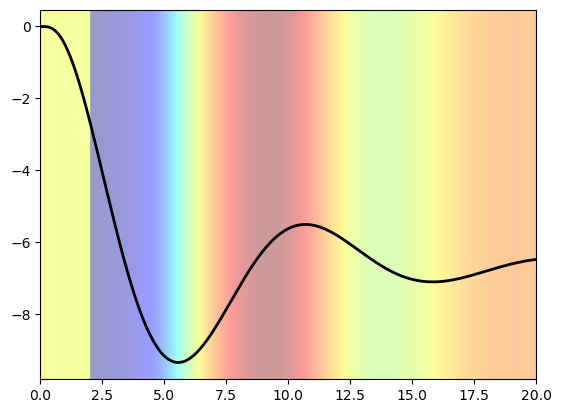

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Create figure and axis
fig, ax = plt.subplots()

# Plot your line
ax.plot(t, x_rnd, color='black', linewidth=2)

# Add a colormap background using imshow
# Reshape values to (1, len(x)) so it's a 1-row image
cmap = plt.get_cmap('jet')
extent = [t.min(), t.max(), ax.get_ylim()[0], ax.get_ylim()[1]]

col_values = np.concatenate([
    np.zeros(len(x_rnd)-len(cum_dist)), cum_dist
])
#col_values = equalize_hist(col_values)
ax.imshow(col_values.reshape(1, -1), aspect='auto', cmap=cmap,
          extent=extent, alpha=0.4)

plt.show()

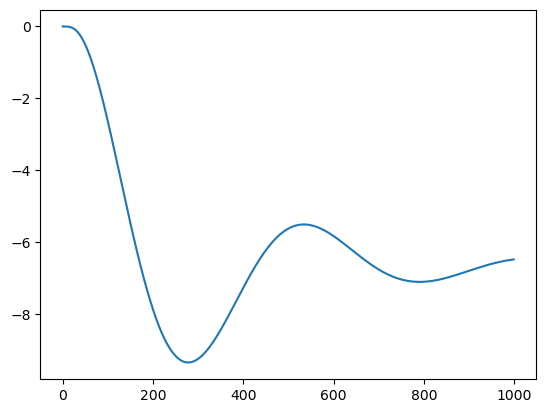

(1000,) 100
(128, 899)


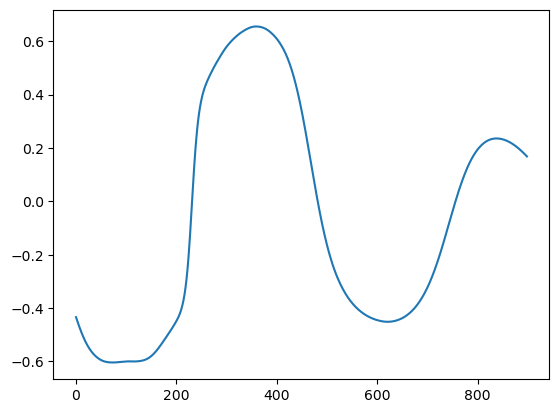

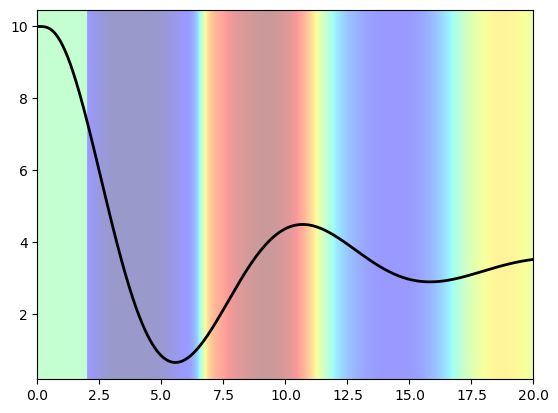

In [307]:
x_rnd = y[0]
plt.plot(x_rnd)
plt.show()

embed_rnd = embed_rolling(x_rnd+10, window_size)
embed_rnd.shape

lag=1
c0_ex0_emb_rpt = np.array([c0_ex0_emb for i in range(len(x_rnd)-window_size-1)]).T
print(c0_ex0_emb_rpt.shape)
cum_dist = -F.cosine_similarity(
    torch.tensor(embed_rnd[:,:-lag]), torch.from_numpy(c0_ex0_emb_rpt), dim=0
).numpy()
#cum_dist = -np.log(-cum_dist)
cum_dist *= -1
plt.plot(cum_dist)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Create figure and axis
fig, ax = plt.subplots()

# Plot your line
ax.plot(t, x_rnd+10, color='black', linewidth=2)

# Add a colormap background using imshow
# Reshape values to (1, len(x)) so it's a 1-row image
cmap = plt.get_cmap('jet')
extent = [t.min(), t.max(), ax.get_ylim()[0], ax.get_ylim()[1]]

col_values = np.concatenate([
    np.zeros(len(x_rnd)-len(cum_dist)), cum_dist
])
#col_values = equalize_hist(col_values)
ax.imshow(col_values.reshape(1, -1), aspect='auto', cmap=cmap,
          extent=extent, alpha=0.4)

plt.show()

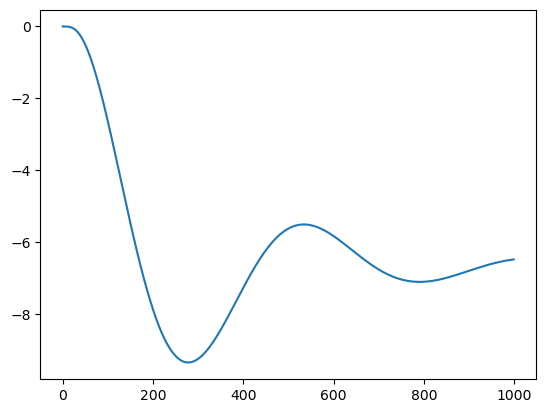

(1000,) 100
(128, 899)


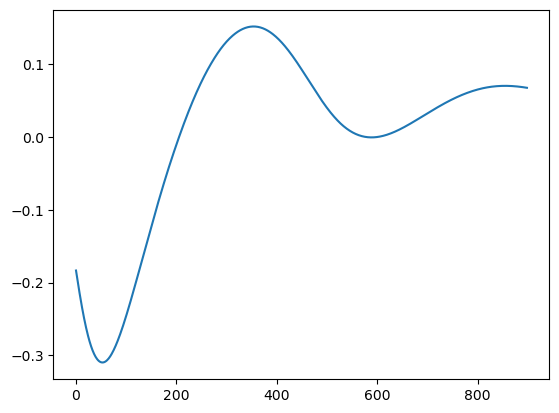

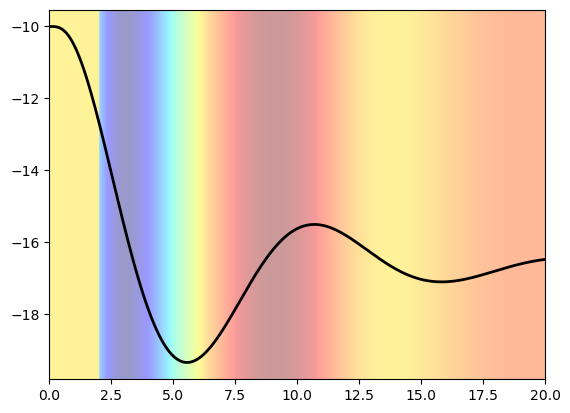

In [308]:
x_rnd = y[0]
plt.plot(x_rnd)
plt.show()

embed_rnd = embed_rolling(x_rnd-10, window_size)
embed_rnd.shape

lag=1
c0_ex0_emb_rpt = np.array([c0_ex0_emb for i in range(len(x_rnd)-window_size-1)]).T
print(c0_ex0_emb_rpt.shape)
cum_dist = -F.cosine_similarity(
    torch.tensor(embed_rnd[:,:-lag]), torch.from_numpy(c0_ex0_emb_rpt), dim=0
).numpy()
#cum_dist = -np.log(-cum_dist)
cum_dist *= -1
plt.plot(cum_dist)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Create figure and axis
fig, ax = plt.subplots()

# Plot your line
ax.plot(t, x_rnd-10, color='black', linewidth=2)

# Add a colormap background using imshow
# Reshape values to (1, len(x)) so it's a 1-row image
cmap = plt.get_cmap('jet')
extent = [t.min(), t.max(), ax.get_ylim()[0], ax.get_ylim()[1]]

col_values = np.concatenate([
    np.zeros(len(x_rnd)-len(cum_dist)), cum_dist
])
#col_values = equalize_hist(col_values)
ax.imshow(col_values.reshape(1, -1), aspect='auto', cmap=cmap,
          extent=extent, alpha=0.4)

plt.show()